## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [3]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [4]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [5]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

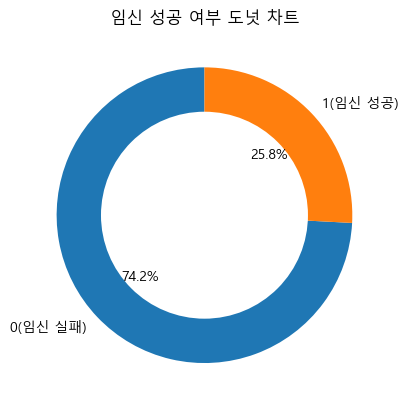

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [7]:
# '시술_시기_코드' 변수의 값이 'TRZKPL'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_시기_코드'] == 'TRZKPL'] 
IVF_test = test[test['시술_시기_코드'] == 'TRZKPL']

# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

train = IVF_train
test = IVF_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [8]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                0        1      0     1  Total
variable                                      
TRZKPL    0.74488  0.25512  26476  9068  35544


In [9]:
# '시술_시기_코드' 변수 제거
train = train.drop(columns=['시술_시기_코드'])
test = test.drop(columns=['시술_시기_코드'])

### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [10]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
만18-34세   0.683490  0.316510  9940.0  4603.0  14543
만35-37세   0.722564  0.277436  5761.0  2212.0   7973
만38-39세   0.792606  0.207394  4502.0  1178.0   5680
만40-42세   0.839186  0.160814  4206.0   806.0   5012
만43-44세   0.891803  0.108197  1360.0   165.0   1525
만45-50세   0.867853  0.132147   683.0   104.0    787
알 수 없음    1.000000  0.000000    24.0     0.0     24


In [11]:
test['시술_당시_나이'].value_counts()

만18-34세    5292
만35-37세    2915
만38-39세    1948
만40-42세    1829
만43-44세     520
만45-50세     282
알 수 없음        7
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [12]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.750000  0.250000    3.0   1.0      4
1.0       0.000000  1.000000    0.0   2.0      2
2.0       1.000000  0.000000    2.0   0.0      2
3.0       0.625000  0.375000    5.0   3.0      8
4.0       0.785714  0.214286   44.0  12.0     56
5.0       0.789855  0.210145  109.0  29.0    138
6.0       0.765957  0.234043  216.0  66.0    282
7.0       0.731707  0.268293  270.0  99.0    369
8.0       0.767647  0.232353  261.0  79.0    340
9.0       0.782143  0.217857  219.0  61.0    280
10.0      0.759091  0.240909  167.0  53.0    220
11.0      0.778409  0.221591  137.0  39.0    176
12.0      0.780702  0.219298   89.0  25.0    114
13.0      0.800000  0.200000   76.0  19.0     95
14.0      0.761905  0.238095   48.0  15.0     63
15.0      0.828125  0.171875   53.0  11.0     64
16.0      0.804348  0.195652   37.0   9.0     46
17.0      0.862069  0.13793

In [13]:
# 3년 단위로 범주화
bins = list(range(0, 24, 3))  # 0부터 20까지 3년 단위로 구간 생성
labels = [f'{i}-{i+2}년' for i in range(0, 21, 3)]  # 범주 레이블 생성

train['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(train['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)
test['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(test['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)

# 결측값을 'unknown'으로 채우기 위해 범주에 'unknown' 추가
train['임신_시도_또는_마지막_임신_경과_연수'] = train['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])
test['임신_시도_또는_마지막_임신_경과_연수'] = test['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])

train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

In [14]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0-2년      0.625000  0.375000      5     3      8
3-5년      0.782178  0.217822    158    44    202
6-8년      0.753784  0.246216    747   244    991
9-11년     0.773669  0.226331    523   153    676
12-14년    0.783088  0.216912    213    59    272
15-17년    0.827338  0.172662    115    24    139
18-20년    0.934426  0.065574     57     4     61
unknown   0.742823  0.257177  24658  8537  33195


### 4. 시술_유형

IVF 또는 DI 시술 여부

In [15]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
DI        0.876890  0.123110    812   114    926
IVF       0.741348  0.258652  25664  8954  34618


In [16]:
test['시술_유형'].value_counts()

IVF    12491
DI       302
Name: 시술_유형, dtype: int64

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [17]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                                  group  '임신_성공_여부' count     ratio  Total
0                            Generic DI                 3  0.375000      8
1                                   ICI                 3  0.100000     30
2                                  ICSI              4354  0.264119  16485
3                             ICSI / AH                75  0.214286    350
4                    ICSI / BLASTOCYST                244  0.344147    709
5               ICSI / BLASTOCYST :ICSI                 1  1.000000      1
6   ICSI / BLASTOCYST :IVF / BLASTOCYST                 0  0.000000      3
7    ICSI / BLASTOCYST:IVF / BLASTOCYST                 0  0.000000      3
8                             ICSI:ICSI                 1  0.007937    126
9                              ICSI:IVF                36  0.290323    124
10                         ICSI:Unknown                 0  0.000000     19
11                                  IUI               108  0.122449    882
12 

In [18]:
test['특정_시술_유형'].value_counts()

ICSI                                  6152
IVF                                   4406
Unknown                               1182
IUI                                    289
ICSI / BLASTOCYST                      277
IVF / BLASTOCYST                       164
ICSI / AH                              113
ICSI:IVF                                51
ICSI:ICSI                               50
IVF / AH                                44
IVF:IVF                                 25
IVF:ICSI                                14
ICI                                      9
ICSI:Unknown                             8
IVF:Unknown                              4
Generic DI                               3
ICSI / BLASTOCYST:IVF / BLASTOCYST       1
IVI                                      1
Name: 특정_시술_유형, dtype: int64

In [19]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [20]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [21]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1        0       1  Total
variable                                                     
Generic DI         0.625000  0.375000      5.0     3.0      8
ICI                0.900000  0.100000     27.0     3.0     30
ICSI               0.737913  0.262087  12363.0  4391.0  16754
ICSI / AH          0.785714  0.214286    275.0    75.0    350
ICSI / BLASTOCYST  0.657821  0.342179    471.0   245.0    716
IUI                0.877551  0.122449    774.0   108.0    882
IVF                0.736871  0.263129   9303.0  3322.0  12625
IVF / AH           0.846154  0.153846    110.0    20.0    130
IVF / BLASTOCYST   0.607477  0.392523    325.0   210.0    535
IVI                1.000000  0.000000      6.0     0.0      6
Unknown            0.803022  0.196978   2817.0   691.0   3508


In [22]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 6261
IVF                  4449
Unknown              1182
IUI                   289
ICSI / BLASTOCYST     278
IVF / BLASTOCYST      164
ICSI / AH             113
IVF / AH               44
ICI                     9
Generic DI              3
IVI                     1
Name: 변환된_특정_시술_유형, dtype: int64

In [23]:
# 더미 변수 생성 함수 정의
def create_dummy(x, keyword):
    if isinstance(x, str) and keyword in x:
        return 1
    else:
        return 0

# 더미 변수 생성
train['특정_시술_유형_ICSI_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
train['특정_시술_유형_IVF_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
train['특정_시술_유형_AH_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
train['특정_시술_유형_BLASTOCYST_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

test['특정_시술_유형_ICSI_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
test['특정_시술_유형_IVF_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
test['특정_시술_유형_AH_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
test['특정_시술_유형_BLASTOCYST_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

In [24]:
summarize_group(train, ['특정_시술_유형',
                        '특정_시술_유형_ICSI_더미',
                          '특정_시술_유형_IVF_더미',
                            '특정_시술_유형_AH_더미',
                              '특정_시술_유형_BLASTOCYST_더미'])

Grouped by: 특정_시술_유형, 특정_시술_유형_ICSI_더미, 특정_시술_유형_IVF_더미, 특정_시술_유형_AH_더미, 특정_시술_유형_BLASTOCYST_더미

                                                group  '임신_성공_여부' count  \
0                            (Generic DI, 0, 0, 0, 0)                 3   
1                                   (ICI, 0, 0, 0, 0)                 3   
2                                  (ICSI, 1, 0, 0, 0)              4354   
3                             (ICSI / AH, 1, 0, 1, 0)                75   
4                    (ICSI / BLASTOCYST , 1, 0, 0, 1)               244   
5               (ICSI / BLASTOCYST :ICSI, 1, 0, 0, 1)                 1   
6   (ICSI / BLASTOCYST :IVF / BLASTOCYST, 1, 0, 0, 1)                 0   
7    (ICSI / BLASTOCYST:IVF / BLASTOCYST, 1, 0, 0, 1)                 0   
8                             (ICSI:ICSI, 1, 0, 0, 0)                 1   
9                              (ICSI:IVF, 1, 0, 0, 0)                36   
10                         (ICSI:Unknown, 1, 0, 0, 0)                 0   
11 

In [25]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [26]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.799947  0.200053   6034  1509   7543
1         0.730045  0.269955  20442  7559  28001


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [27]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                   0         1        0       1  Total
variable                                              
기록되지 않은 시행  0.727570  0.272430  20006.0  7491.0  27497
생식선 자극 호르몬  0.000000  1.000000      0.0     1.0      1
알 수 없음      0.804126  0.195874   6470.0  1576.0   8046


In [28]:
test['배란_유도_유형'].value_counts()

기록되지 않은 시행    9999
알 수 없음        2794
Name: 배란_유도_유형, dtype: int64

### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [29]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.761428  0.238572  21671  6790  28461
1.0       0.648530  0.351470   3993  2164   6157


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [30]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.846809  0.153191  199  36    235


In [31]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 35309
결측값 개수: 0


In [32]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.744201  0.255799  26277  9032  35309
1.0       0.846809  0.153191    199    36    235


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [33]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.741470  0.258530  25448  8873  34321
1.0       0.727273  0.272727    216    81    297


In [34]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              8837  0.259256  34086
1  (0.0, 1.0)                36  0.153191    235
2  (1.0, 0.0)                81  0.272727    297


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [35]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743568  0.256432  25085  8651  33736
1         0.769358  0.230642   1391   417   1808


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [36]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743383  0.256617  25785  8901  34686
1         0.805361  0.194639    691   167    858


In [37]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              8484  0.258037  32879
1  (0, 1)               167  0.194866    857
2  (1, 0)               417  0.230769   1807
3  (1, 1)                 0  0.000000      1


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [38]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                0        1      0     1  Total
variable                                      
0         0.74339  0.25661  24969  8619  33588
1         0.77045  0.22955   1507   449   1956


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [39]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743309  0.256691  25830  8920  34750
1         0.813602  0.186398    646   148    794


In [40]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              8471  0.258278  32798
1  (0, 1)               148  0.187342    790
2  (1, 0)               449  0.230020   1952
3  (1, 1)                 0  0.000000      4


In [41]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

           group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0)              8466  0.258251  32782
1   (0, 0, 0, 1)                 3  0.103448     29
2   (0, 0, 1, 0)                15  0.223881     67
3   (0, 0, 1, 1)                 0  0.000000      1
4   (0, 1, 0, 0)                 0  0.000000      1
5   (0, 1, 0, 1)               103  0.190037    542
6   (0, 1, 1, 0)                64  0.203822    314
7   (1, 0, 0, 0)                 5  0.333333     15
8   (1, 0, 0, 1)                42  0.191781    219
9   (1, 0, 1, 0)               370  0.235519   1571
10  (1, 0, 1, 1)                 0  0.000000      2
11  (1, 1, 1, 1)                 0  0.000000      1


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [42]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742994  0.257006  24816  8584  33400
1         0.774254  0.225746   1660   484   2144


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [43]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743856  0.256144  26029  8963  34992
1         0.809783  0.190217    447   105    552


In [44]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              8479  0.258105  32851
1  (0, 1)               105  0.191257    549
2  (1, 0)               484  0.226063   2141
3  (1, 1)                 0  0.000000      3


In [45]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0, 0, 0)              8463  0.258262  32769
1   (0, 0, 0, 0, 0, 1)                 0  0.000000      3
2   (0, 0, 0, 0, 1, 0)                 3  0.300000     10
3   (0, 0, 0, 1, 0, 0)                 3  0.150000     20
4   (0, 0, 0, 1, 0, 1)                 0  0.000000      6
5   (0, 0, 0, 1, 1, 0)                 0  0.000000      3
6   (0, 0, 1, 0, 0, 0)                10  0.232558     43
7   (0, 0, 1, 0, 1, 0)                 5  0.208333     24
8   (0, 0, 1, 1, 1, 0)                 0  0.000000      1
9   (0, 1, 0, 0, 0, 0)                 0  0.000000      1
10  (0, 1, 0, 1, 0, 0)                 1  0.125000      8
11  (0, 1, 0, 1, 0, 1)                90  0.191083    471
12  (0, 1, 0, 1, 1, 0)                12  0.196721     61
13  (0, 1, 0, 1, 1, 1)                 0  0.000000      2
14  (0, 1, 1, 0, 0, 1)                12  0.19

### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [46]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.748173  0.251827  19965  6720  26685
1         0.734959  0.265041   6511  2348   8859


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [47]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741996  0.258004  22271  7744  30015
1         0.760535  0.239465   4205  1324   5529


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [48]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.754609  0.245391  16372  5324  21696
1         0.729636  0.270364  10104  3744  13848


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [49]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.747902  0.252098  23170  7810  30980
1         0.724365  0.275635   3306  1258   4564


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [50]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                0        1      0     1  Total
variable                                      
0         0.74488  0.25512  26476  9068  35544


In [51]:
test['불임_원인_-_여성_요인'].value_counts()

0    12793
Name: 불임_원인_-_여성_요인, dtype: int64

In [52]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [53]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                0        1      0     1  Total
variable                                      
0         0.74488  0.25512  26476  9068  35544


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [54]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743807  0.256193  24562  8460  33022
1         0.758921  0.241079   1914   608   2522


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [55]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.744863  0.255137  26427  9052  35479
1         0.753846  0.246154     49    16     65


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [56]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                0        1      0     1  Total
variable                                      
0         0.74488  0.25512  26476  9068  35544


In [57]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

0    12793
Name: 불임_원인_-_정자_면역학적_요인, dtype: int64

In [58]:
# '불임_원인_-_정자_면역학적_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_면역학적_요인'])
test = test.drop(columns=['불임_원인_-_정자_면역학적_요인'])

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [59]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.744784  0.255216  26451  9064  35515
1         0.862069  0.137931     25     4     29


In [60]:
# '불임_원인_-_정자_운동성' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_운동성'])
test = test.drop(columns=['불임_원인_-_정자_운동성'])

### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [61]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.744859  0.255141  26444  9058  35502
1         0.761905  0.238095     32    10     42


### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [62]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    109.0     0.0    109
기증용, 난자 저장용          1.000000  0.000000      6.0     0.0      6
기증용, 배아 저장용          1.000000  0.000000      4.0     0.0      4
기증용, 배아 저장용, 현재 시술용  1.000000  0.000000      1.0     0.0      1
기증용, 현재 시술용          0.620272  0.379728    410.0   251.0    661
난자 저장용               1.000000  0.000000    170.0     0.0    170
난자 저장용, 현재 시술용       0.750000  0.250000      3.0     1.0      4
배아 저장용               1.000000  0.000000    178.0     0.0    178
배아 저장용, 현재 시술용       1.000000  0.000000      1.0     0.0      1
현재 시술용               0.740115  0.259885  24782.0  8702.0  33484


In [63]:
# '연구용'이라는 값이 포함된 행 삭제
train = train[~train['배아_생성_주요_이유'].str.contains('연구용', na=False)]
# test = test[~test['배아_생성_주요_이유'].str.contains('연구용', na=False)]

In [64]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    109.0     0.0    109
기증용, 난자 저장용          1.000000  0.000000      6.0     0.0      6
기증용, 배아 저장용          1.000000  0.000000      4.0     0.0      4
기증용, 배아 저장용, 현재 시술용  1.000000  0.000000      1.0     0.0      1
기증용, 현재 시술용          0.620272  0.379728    410.0   251.0    661
난자 저장용               1.000000  0.000000    170.0     0.0    170
난자 저장용, 현재 시술용       0.750000  0.250000      3.0     1.0      4
배아 저장용               1.000000  0.000000    178.0     0.0    178
배아 저장용, 현재 시술용       1.000000  0.000000      1.0     0.0      1
현재 시술용               0.740115  0.259885  24782.0  8702.0  33484


In [65]:
test['배아_생성_주요_이유'].value_counts()

현재 시술용                 12098
기증용, 현재 시술용              231
배아 저장용                    62
난자 저장용                    59
기증용                       35
기증용, 배아 저장용, 현재 시술용        2
기증용, 배아 저장용                2
난자 저장용, 현재 시술용             1
배아 저장용, 현재 시술용             1
Name: 배아_생성_주요_이유, dtype: int64

In [66]:
print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

train['배아_생성_주요_이유'].fillna('unknown', inplace=True)
test['배아_생성_주요_이유'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

결측값 개수: 926
결측값 개수: 0


In [67]:
# '현재 시술용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_현재시술용'] = train['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)
test['배아_생성_주요_이유_현재시술용'] = test['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)

In [68]:
# '기증용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_기증용'] = train['배아_생성_주요_이유'].str.contains('기증용').astype(int)
test['배아_생성_주요_이유_기증용'] = test['배아_생성_주요_이유'].str.contains('기증용').astype(int)

In [69]:
# '난자 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_난자저장용'] = train['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)
test['배아_생성_주요_이유_난자저장용'] = test['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)

In [70]:
# '배아 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_배아저장용'] = train['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)
test['배아_생성_주요_이유_배아저장용'] = test['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)

In [71]:
summarize_group(train, [
    # '배아_생성_주요_이유',
    '배아_생성_주요_이유_현재시술용',
    '배아_생성_주요_이유_기증용',
    '배아_생성_주요_이유_난자저장용',
    '배아_생성_주요_이유_배아저장용'
                        ])

Grouped by: 배아_생성_주요_이유_현재시술용, 배아_생성_주요_이유_기증용, 배아_생성_주요_이유_난자저장용, 배아_생성_주요_이유_배아저장용

           group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0)               114  0.123110    926
1   (0, 0, 0, 1)                 0  0.000000    178
2   (0, 0, 1, 0)                 0  0.000000    170
3   (0, 1, 0, 0)                 0  0.000000    109
4   (0, 1, 0, 1)                 0  0.000000      4
5   (0, 1, 1, 0)                 0  0.000000      6
6   (1, 0, 0, 0)              8702  0.259885  33484
7   (1, 0, 0, 1)                 0  0.000000      1
8   (1, 0, 1, 0)                 1  0.250000      4
9   (1, 1, 0, 0)               251  0.379728    661
10  (1, 1, 0, 1)                 0  0.000000      1


In [72]:
value_counts_ratio(train, '배아_생성_주요_이유_현재시술용')


배아_생성_주요_이유_현재시술용별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.918162  0.081838   1279   114   1393
1         0.737811  0.262189  25197  8954  34151


In [73]:
# # 변수 제거
# train = train.drop(columns=['배아_생성_주요_이유'])
# test = test.drop(columns=['배아_생성_주요_이유'])

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [74]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0회        0.703421  0.296579  9046  3814  12860
1회        0.752582  0.247418  6339  2084   8423
2회        0.770441  0.229559  4504  1342   5846
3회        0.768692  0.231308  2632   792   3424
4회        0.773236  0.226764  1589   466   2055
5회        0.802653  0.197347   968   238   1206
6회 이상     0.808092  0.191908  1398   332   1730


In [75]:
test['총_시술_횟수'].value_counts()

0회       4710
1회       3034
2회       2016
3회       1241
4회        757
6회 이상     590
5회        445
Name: 총_시술_횟수, dtype: int64

In [76]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0         0.703421  0.296579  9046  3814  12860
1         0.752582  0.247418  6339  2084   8423
2         0.770441  0.229559  4504  1342   5846
3         0.768692  0.231308  2632   792   3424
4         0.773236  0.226764  1589   466   2055
5         0.802653  0.197347   968   238   1206
6         0.808092  0.191908  1398   332   1730


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [77]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.713461  0.286539  11613  4664  16277
1회        0.757669  0.242331   6644  2125   8769
2회        0.775252  0.224748   3922  1137   5059
3회        0.771485  0.228515   1948   577   2525
4회        0.790732  0.209268   1058   280   1338
5회        0.816552  0.183448    592   133    725
6회 이상     0.821387  0.178613    699   152    851


In [78]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.713461  0.286539  11613  4664  16277
1         0.757669  0.242331   6644  2125   8769
2         0.775252  0.224748   3922  1137   5059
3         0.771485  0.228515   1948   577   2525
4         0.790732  0.209268   1058   280   1338
5         0.816552  0.183448    592   133    725
6         0.821387  0.178613    699   152    851


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [79]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0회        0.707631  0.292369  9737  4023  13760
1회        0.752902  0.247098  6487  2129   8616
2회        0.771945  0.228055  4485  1325   5810
3회        0.772348  0.227652  2497   736   3233
4회        0.771536  0.228464  1442   427   1869
5회        0.803554  0.196446   814   199   1013
6회 이상     0.815768  0.184232  1014   229   1243


In [80]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0         0.707631  0.292369  9737  4023  13760
1         0.752902  0.247098  6487  2129   8616
2         0.771945  0.228055  4485  1325   5810
3         0.772348  0.227652  2497   736   3233
4         0.771536  0.228464  1442   427   1869
5         0.803554  0.196446   814   199   1013
6         0.815768  0.184232  1014   229   1243


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [81]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.742366  0.257634  24991  8673  33664
1회        0.809278  0.190722    314    74    388
2회        0.783375  0.216625    311    86    397
3회        0.765789  0.234211    291    89    380
4회        0.840816  0.159184    206    39    245
5회        0.797872  0.202128    150    38    188
6회 이상     0.755319  0.244681    213    69    282


In [82]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742366  0.257634  24991  8673  33664
1         0.809278  0.190722    314    74    388
2         0.783375  0.216625    311    86    397
3         0.765789  0.234211    291    89    380
4         0.840816  0.159184    206    39    245
5         0.797872  0.202128    150    38    188
6         0.755319  0.244681    213    69    282


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [83]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.745776  0.254224  21365.0  7283.0  28648
1회        0.740106  0.259894   4488.0  1576.0   6064
2회        0.748641  0.251359    551.0   185.0    736
3회        0.753086  0.246914     61.0    20.0     81
4회        0.750000  0.250000      9.0     3.0     12
5회        0.500000  0.500000      1.0     1.0      2
6회 이상     1.000000  0.000000      1.0     0.0      1


In [84]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.745776  0.254224  21365.0  7283.0  28648
1         0.740106  0.259894   4488.0  1576.0   6064
2         0.748641  0.251359    551.0   185.0    736
3         0.753086  0.246914     61.0    20.0     81
4         0.750000  0.250000      9.0     3.0     12
5         0.500000  0.500000      1.0     1.0      2
6         1.000000  0.000000      1.0     0.0      1


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [85]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.745640  0.254360  21634.0  7380.0  29014
1회        0.739100  0.260900   4255.0  1502.0   5757
2회        0.756204  0.243796    518.0   167.0    685
3회        0.786667  0.213333     59.0    16.0     75
4회        0.750000  0.250000      9.0     3.0     12
5회        1.000000  0.000000      1.0     0.0      1


In [86]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.745640  0.254360  21634.0  7380.0  29014
1         0.739100  0.260900   4255.0  1502.0   5757
2         0.756204  0.243796    518.0   167.0    685
3         0.786667  0.213333     59.0    16.0     75
4         0.750000  0.250000      9.0     3.0     12
5         1.000000  0.000000      1.0     0.0      1


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [87]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.745023  0.254977  26195  8965  35160
1회        0.752212  0.247788    255    84    339
2회        0.600000  0.400000     24    16     40
3회        0.333333  0.666667      1     2      3
5회        0.500000  0.500000      1     1      2


In [88]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.745023  0.254977  26195  8965  35160
1         0.752212  0.247788    255    84    339
2         0.600000  0.400000     24    16     40
3         0.333333  0.666667      1     2      3
5         0.500000  0.500000      1     1      2


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [89]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.745471  0.254529  22672.0  7741.0  30413
1회        0.742262  0.257738   3597.0  1249.0   4846
2회        0.724806  0.275194    187.0    71.0    258
3회        0.714286  0.285714     15.0     6.0     21
4회        0.800000  0.200000      4.0     1.0      5
6회 이상     1.000000  0.000000      1.0     0.0      1


In [90]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.745471  0.254529  22672.0  7741.0  30413
1         0.742262  0.257738   3597.0  1249.0   4846
2         0.724806  0.275194    187.0    71.0    258
3         0.714286  0.285714     15.0     6.0     21
4         0.800000  0.200000      4.0     1.0      5
6         1.000000  0.000000      1.0     0.0      1


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [91]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.745466  0.254534  22894  7817  30711
1회        0.741308  0.258692   3390  1183   4573
2회        0.733051  0.266949    173    63    236
3회        0.789474  0.210526     15     4     19
4회        0.800000  0.200000      4     1      5


In [92]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.745466  0.254534  22894  7817  30711
1         0.741308  0.258692   3390  1183   4573
2         0.733051  0.266949    173    63    236
3         0.789474  0.210526     15     4     19
4         0.800000  0.200000      4     1      5


In [93]:
test['IVF_출산_횟수'].value_counts()

0    11051
1     1667
2       73
3        2
Name: IVF_출산_횟수, dtype: int64

### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [94]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.744885  0.255115  26249.0  8990.0  35239
1회        0.755245  0.244755    216.0    70.0    286
2회        0.625000  0.375000     10.0     6.0     16
3회        0.000000  1.000000      0.0     2.0      2
5회        1.000000  0.000000      1.0     0.0      1


In [95]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.744885  0.255115  26249.0  8990.0  35239
1         0.755245  0.244755    216.0    70.0    286
2         0.625000  0.375000     10.0     6.0     16
3         0.000000  1.000000      0.0     2.0      2
5         1.000000  0.000000      1.0     0.0      1


In [96]:
test['DI_출산_횟수'].value_counts()

0    12689
1       96
2        8
Name: DI_출산_횟수, dtype: int64

In [97]:
# # 모든 행과 열을 다 보이게 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [98]:
# summarize_group(train, ['IVF_시술_횟수', 'IVF_임신_횟수', 'IVF_출산_횟수'])

In [99]:
# 주요 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], 0)
train['IVF_출산_임신_비율'] = np.where(train['IVF_임신_횟수'] > 0, train['IVF_출산_횟수'] / train['IVF_임신_횟수'], 0)

train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], 0)
train['DI_출산_임신_비율'] = np.where(train['DI_임신_횟수'] > 0, train['DI_출산_횟수'] / train['DI_임신_횟수'], 0)

# 성공률 계산
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], 0)
train['출산_성공률'] = np.where(train['총_임신_횟수'] > 0, train['총_출산_횟수'] / train['총_임신_횟수'], 0)

# 주요 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], 0)
test['IVF_출산_임신_비율'] = np.where(test['IVF_임신_횟수'] > 0, test['IVF_출산_횟수'] / test['IVF_임신_횟수'], 0)

test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], 0)
test['DI_출산_임신_비율'] = np.where(test['DI_임신_횟수'] > 0, test['DI_출산_횟수'] / test['DI_임신_횟수'], 0)

# 성공률 계산
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], 0)
test['출산_성공률'] = np.where(test['총_임신_횟수'] > 0, test['총_출산_횟수'] / test['총_임신_횟수'], 0)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [100]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.855876  0.144124  6081.0  1024.0   7105
1.0       0.901416  0.098584  1783.0   195.0   1978
2.0       0.819878  0.180122  2153.0   473.0   2626
3.0       0.747654  0.252346  2151.0   726.0   2877
4.0       0.725879  0.274121  2272.0   858.0   3130
5.0       0.690053  0.309947  2095.0   941.0   3036
6.0       0.688512  0.311488  1786.0   808.0   2594
7.0       0.668412  0.331588  1532.0   760.0   2292
8.0       0.649698  0.350302  1289.0   695.0   1984
9.0       0.641397  0.358603   973.0   544.0   1517
10.0      0.639498  0.360502   816.0   460.0   1276
11.0      0.635721  0.364279   630.0   361.0    991
12.0      0.649937  0.350063   518.0   279.0    797
13.0      0.636213  0.363787   383.0   219.0    602
14.0      0.651316  0.348684   297.0   159.0    456
15.0      0.610465  0.389535   210.0   134.0    344
16.0      0.662745  0.337255   169

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [101]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.752363  0.247637  13213.0  4349.0  17562
1.0       0.951264  0.048736    527.0    27.0    554
2.0       0.896985  0.103015    714.0    82.0    796
3.0       0.821662  0.178338    880.0   191.0   1071
4.0       0.805680  0.194320   1078.0   260.0   1338
5.0       0.761056  0.238944   1153.0   362.0   1515
6.0       0.723214  0.276786   1134.0   434.0   1568
7.0       0.724696  0.275304   1074.0   408.0   1482
8.0       0.682236  0.317764    964.0   449.0   1413
9.0       0.697865  0.302135    850.0   368.0   1218
10.0      0.686078  0.313922    754.0   345.0   1099
11.0      0.666667  0.333333    612.0   306.0    918
12.0      0.676240  0.323760    518.0   248.0    766
13.0      0.638681  0.361319    426.0   241.0    667
14.0      0.655477  0.344523    371.0   195.0    566
15.0      0.654428  0.345572    303.0   160.0    463
16.0      0.667

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [102]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.759892  0.240108  13770.0  4351.0  18121
1.0       0.911880  0.088120   1159.0   112.0   1271
2.0       0.818395  0.181605   1397.0   310.0   1707
3.0       0.751309  0.248691   1435.0   475.0   1910
4.0       0.745976  0.254024   1483.0   505.0   1988
5.0       0.687468  0.312532   1333.0   606.0   1939
6.0       0.690696  0.309304   1121.0   502.0   1623
7.0       0.676981  0.323019    897.0   428.0   1325
8.0       0.666100  0.333900    784.0   393.0   1177
9.0       0.643304  0.356696    514.0   285.0    799
10.0      0.639586  0.360414    433.0   244.0    677
11.0      0.621415  0.378585    325.0   198.0    523
12.0      0.671569  0.328431    274.0   134.0    408
13.0      0.613115  0.386885    187.0   118.0    305
14.0      0.662338  0.337662    153.0    78.0    231
15.0      0.610063  0.389937     97.0    62.0    159
16.0      

### 42. 이식된_배아_수

이식된 배아의 총 수

In [103]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.999726  0.000274   3651     1   3652
1.0       0.715000  0.285000   8008  3192  11200
2.0       0.698764  0.301236  12721  5484  18205
3.0       0.822550  0.177450   1284   277   1561


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [104]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.768635  0.231365  14096  4243  18339
1.0       0.718099  0.281901   4035  1584   5619
2.0       0.695317  0.304683   6771  2967   9738
3.0       0.826464  0.173536    762   160    922


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [105]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.780487  0.219513  19271.0  5420.0  24691
1.0       0.629785  0.370215   1497.0   880.0   2377
2.0       0.617048  0.382952   1484.0   921.0   2405
3.0       0.611931  0.388069    995.0   631.0   1626
4.0       0.626629  0.373371    673.0   401.0   1074
5.0       0.630556  0.369444    454.0   266.0    720
6.0       0.680328  0.319672    332.0   156.0    488
7.0       0.692308  0.307692    216.0    96.0    312
8.0       0.695238  0.304762    146.0    64.0    210
9.0       0.681818  0.318182    105.0    49.0    154
10.0      0.731707  0.268293     90.0    33.0    123
11.0      0.830769  0.169231     54.0    11.0     65
12.0      0.716418  0.283582     48.0    19.0     67
13.0      0.962963  0.037037     52.0     2.0     54
14.0      0.960784  0.039216     49.0     2.0     51
15.0      0.973684  0.026316     37.0     1.0     38
16.0      0.93103

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [106]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.758346  0.241654  22149.0  7058.0  29207
1.0       0.623790  0.376210    902.0   544.0   1446
2.0       0.619188  0.380812    839.0   516.0   1355
3.0       0.624424  0.375576    542.0   326.0    868
4.0       0.632576  0.367424    334.0   194.0    528
5.0       0.643617  0.356383    242.0   134.0    376
6.0       0.700422  0.299578    166.0    71.0    237
7.0       0.757143  0.242857    106.0    34.0    140
8.0       0.776699  0.223301     80.0    23.0    103
9.0       0.719512  0.280488     59.0    23.0     82
10.0      0.730769  0.269231     38.0    14.0     52
11.0      0.781250  0.218750     25.0     7.0     32
12.0      0.771429  0.228571     27.0     8.0     35
13.0      0.925926  0.074074     25.0     2.0     27
14.0      1.000000  0.000000     27.0     0.0     27
15.0      1.000000  0.000000     19.0     0.0     19
16.0      

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [107]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.728255  0.271745  21241.0  7926.0  29167
1.0       0.839316  0.160684    982.0   188.0   1170
2.0       0.815534  0.184466   1344.0   304.0   1648
3.0       0.822616  0.177384    742.0   160.0    902
4.0       0.789902  0.210098    485.0   129.0    614
5.0       0.818991  0.181009    276.0    61.0    337
6.0       0.788235  0.211765    201.0    54.0    255
7.0       0.796296  0.203704    129.0    33.0    162
8.0       0.669173  0.330827     89.0    44.0    133
9.0       0.740741  0.259259     40.0    14.0     54
10.0      0.780822  0.219178     57.0    16.0     73
11.0      0.733333  0.266667     22.0     8.0     30
12.0      0.800000  0.200000     16.0     4.0     20
13.0      0.800000  0.200000     12.0     3.0     15
14.0      0.727273  0.272727      8.0     3.0     11
15.0      0.500000  0.500000      3.0     3.0      6
16.0      0.66666

### 47. 해동_난자_수

동결 해동된 난자의 수

In [108]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.741116  0.258884  25590.0  8939.0  34529
1.0       1.000000  0.000000      4.0     0.0      4
2.0       0.833333  0.166667      5.0     1.0      6
3.0       0.625000  0.375000      5.0     3.0      8
4.0       0.888889  0.111111      8.0     1.0      9
5.0       1.000000  0.000000      5.0     0.0      5
6.0       1.000000  0.000000     10.0     0.0     10
7.0       0.750000  0.250000      3.0     1.0      4
8.0       0.666667  0.333333      6.0     3.0      9
9.0       0.909091  0.090909     10.0     1.0     11
10.0      1.000000  0.000000      6.0     0.0      6
11.0      1.000000  0.000000      1.0     0.0      1
12.0      0.800000  0.200000      4.0     1.0      5
13.0      1.000000  0.000000      1.0     0.0      1
14.0      0.666667  0.333333      2.0     1.0      3
15.0      0.500000  0.500000      1.0     1.0      2
16.0      0.000000

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [109]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.797499  0.202501  5612.0  1425.0   7037
1.0       0.943503  0.056497   501.0    30.0    531
2.0       0.917397  0.082603   733.0    66.0    799
3.0       0.866667  0.133333   962.0   148.0   1110
4.0       0.807608  0.192392  1104.0   263.0   1367
5.0       0.796093  0.203907  1304.0   334.0   1638
6.0       0.760882  0.239118  1346.0   423.0   1769
7.0       0.750531  0.249469  1414.0   470.0   1884
8.0       0.705508  0.294492  1332.0   556.0   1888
9.0       0.723599  0.276401  1343.0   513.0   1856
10.0      0.700546  0.299454  1282.0   548.0   1830
11.0      0.684715  0.315285  1214.0   559.0   1773
12.0      0.686654  0.313346  1065.0   486.0   1551
13.0      0.671280  0.328720   970.0   475.0   1445
14.0      0.685004  0.314996   909.0   418.0   1327
15.0      0.642793  0.357207   718.0   399.0   1117
16.0      0.669439  0.330561   6

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [110]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.739618  0.260382  25414.0  8947.0  34361
1.0       1.000000  0.000000     10.0     0.0     10
2.0       1.000000  0.000000     21.0     0.0     21
3.0       1.000000  0.000000     15.0     0.0     15
4.0       0.941176  0.058824     16.0     1.0     17
5.0       0.958333  0.041667     23.0     1.0     24
6.0       1.000000  0.000000     28.0     0.0     28
7.0       0.916667  0.083333     11.0     1.0     12
8.0       0.952381  0.047619     20.0     1.0     21
9.0       1.000000  0.000000     10.0     0.0     10
10.0      1.000000  0.000000     15.0     0.0     15
11.0      1.000000  0.000000     12.0     0.0     12
12.0      0.777778  0.222222      7.0     2.0      9
13.0      1.000000  0.000000     12.0     0.0     12
14.0      1.000000  0.000000     10.0     0.0     10
15.0      0.900000  0.100000      9.0     1.0     10
16.0      1.00

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [111]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.834144  0.165856  5145.0  1023.0   6168
1.0       0.944091  0.055909   743.0    44.0    787
2.0       0.899567  0.100433  1039.0   116.0   1155
3.0       0.829412  0.170588  1269.0   261.0   1530
4.0       0.794818  0.205182  1503.0   388.0   1891
5.0       0.757241  0.242759  1647.0   528.0   2175
6.0       0.726293  0.273707  1685.0   635.0   2320
7.0       0.724525  0.275475  1678.0   638.0   2316
8.0       0.685414  0.314586  1499.0   688.0   2187
9.0       0.697166  0.302834  1402.0   609.0   2011
10.0      0.683019  0.316981  1267.0   588.0   1855
11.0      0.660036  0.339964  1095.0   564.0   1659
12.0      0.661302  0.338698   945.0   484.0   1429
13.0      0.648013  0.351987   799.0   434.0   1233
14.0      0.655424  0.344576   719.0   378.0   1097
15.0      0.646995  0.353005   592.0   323.0    915
16.0      0.655415  0.344585   466.

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [112]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.802736  0.197264  6454.0  1586.0   8040
1.0       0.942069  0.057931   683.0    42.0    725
2.0       0.902439  0.097561   962.0   104.0   1066
3.0       0.828674  0.171326  1156.0   239.0   1395
4.0       0.795571  0.204429  1401.0   360.0   1761
5.0       0.762165  0.237835  1535.0   479.0   2014
6.0       0.727816  0.272184  1583.0   592.0   2175
7.0       0.728200  0.271800  1570.0   586.0   2156
8.0       0.686047  0.313953  1416.0   648.0   2064
9.0       0.700213  0.299787  1315.0   563.0   1878
10.0      0.685099  0.314901  1177.0   541.0   1718
11.0      0.659740  0.340260  1016.0   524.0   1540
12.0      0.663922  0.336078   887.0   449.0   1336
13.0      0.655232  0.344768   764.0   402.0   1166
14.0      0.653140  0.346860   676.0   359.0   1035
15.0      0.647327  0.352673   569.0   310.0    879
16.0      0.659226  0.34077

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [113]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.743408  0.256592  24386.0  8417.0  32803
1.0       0.968254  0.031746     61.0     2.0     63
2.0       0.866667  0.133333     78.0    12.0     90
3.0       0.838235  0.161765    114.0    22.0    136
4.0       0.781955  0.218045    104.0    29.0    133
5.0       0.695122  0.304878    114.0    50.0    164
6.0       0.715232  0.284768    108.0    43.0    151
7.0       0.680982  0.319018    111.0    52.0    163
8.0       0.680328  0.319672     83.0    39.0    122
9.0       0.666667  0.333333     86.0    43.0    129
10.0      0.649254  0.350746     87.0    47.0    134
11.0      0.654867  0.345133     74.0    39.0    113
12.0      0.625000  0.375000     55.0    33.0     88
13.0      0.533333  0.466667     32.0    28.0     60
14.0      0.689655  0.310345     40.0    18.0     58
15.0      0.566667  0.433333     17.0    13.0     30
16.0     

In [114]:
# 1. 임신 성공율 - 이식된 배아 대비 임신 성공 비율
train['임신_성공율'] = np.where(train['총_생성_배아_수'] > 0, (train['이식된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 2. ICSI 효율성 - 미세주입된 난자 대비 생성된 배아 비율
train['ICSI_효율성'] = np.where(train['미세주입된_난자_수'] > 0, (train['미세주입에서_생성된_배아_수'] / train['미세주입된_난자_수']) * 100, 0).round(2)

# 3. 저장 배아 비율 - 총 생성 배아 대비 저장된 배아 수 비율
train['저장_배아_비율'] = np.where(train['총_생성_배아_수'] > 0, (train['저장된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 4. 해동 난자 비율 - 해동된 난자 대비 수집된 신선 난자 비율
train['해동_난자_비율'] = np.where(train['수집된_신선_난자_수'] > 0, (train['해동_난자_수'] / train['수집된_신선_난자_수']) * 100, 0).round(2)

# 5. 생성 배아 유지율 - ICSI 후 저장된 배아 대비 생성된 배아 비율
train['생성_배아_유지율'] = np.where(train['미세주입에서_생성된_배아_수'] > 0, (train['미세주입_후_저장된_배아_수'] / train['미세주입에서_생성된_배아_수']) * 100, 0).round(2)

# 6. 파트너 정자 사용 비율 - 혼합된 난자에서 파트너 정자 비율
train['파트너_정자_사용_비율'] = np.where(train['혼합된_난자_수'] > 0, (train['파트너_정자와_혼합된_난자_수'] / train['혼합된_난자_수']) * 100, 0).round(2)

# test 데이터프레임에도 동일한 파생 변수를 생성
test['임신_성공율'] = np.where(test['총_생성_배아_수'] > 0, (test['이식된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['ICSI_효율성'] = np.where(test['미세주입된_난자_수'] > 0, (test['미세주입에서_생성된_배아_수'] / test['미세주입된_난자_수']) * 100, 0).round(2)
test['저장_배아_비율'] = np.where(test['총_생성_배아_수'] > 0, (test['저장된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['해동_난자_비율'] = np.where(test['수집된_신선_난자_수'] > 0, (test['해동_난자_수'] / test['수집된_신선_난자_수']) * 100, 0).round(2)
test['생성_배아_유지율'] = np.where(test['미세주입에서_생성된_배아_수'] > 0, (test['미세주입_후_저장된_배아_수'] / test['미세주입에서_생성된_배아_수']) * 100, 0).round(2)
test['파트너_정자_사용_비율'] = np.where(test['혼합된_난자_수'] > 0, (test['파트너_정자와_혼합된_난자_수'] / test['혼합된_난자_수']) * 100, 0).round(2)

### 53. 난자_출처

난자 출처 정보

In [115]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
기증 제공     0.715411  0.284589   1272   506   1778
본인 제공     0.742753  0.257247  24392  8448  32840
알 수 없음    0.876890  0.123110    812   114    926


In [116]:
test['난자_출처'].value_counts()

본인 제공     11843
기증 제공       648
알 수 없음      302
Name: 난자_출처, dtype: int64

### 54. 정자_출처

정자 출처 정보

In [117]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1        0       1  Total
variable                                               
기증 제공        0.762754  0.237246   2482.0   772.0   3254
미할당          0.600000  0.400000      3.0     2.0      5
배우자 및 기증 제공  1.000000  0.000000      1.0     0.0      1
배우자 제공       0.743093  0.256907  23990.0  8294.0  32284


In [118]:
test['정자_출처'].value_counts()

배우자 제공         11640
기증 제공           1149
미할당                3
배우자 및 기증 제공        1
Name: 정자_출처, dtype: int64

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [119]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.863636  0.136364     19     3     22
만21-25세   0.712644  0.287356    124    50    174
만26-30세   0.676106  0.323894    382   183    565
만31-35세   0.716285  0.283715    563   223    786
알 수 없음    0.746772  0.253228  25388  8609  33997


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [120]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.869565  0.130435     80    12     92
만21-25세   0.764407  0.235593    451   139    590
만26-30세   0.743083  0.256917    376   130    506
만31-35세   0.777015  0.222985    453   130    583
만36-40세   0.754121  0.245879    549   179    728
만41-45세   0.747387  0.252613    429   145    574
알 수 없음    0.743371  0.256629  24138  8333  32471


In [121]:
summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이'])

Grouped by: 난자_기증자_나이, 정자_기증자_나이

                 group  '임신_성공_여부' count     ratio  Total
0   (만20세 이하, 만36-40세)                 0  0.000000      1
1    (만20세 이하, 알 수 없음)                 3  0.142857     21
2   (만21-25세, 만20세 이하)                 0  0.000000      1
3   (만21-25세, 만21-25세)                 2  0.666667      3
4   (만21-25세, 만26-30세)                 1  1.000000      1
5   (만21-25세, 만31-35세)                 0  0.000000      3
6   (만21-25세, 만36-40세)                 1  0.200000      5
7   (만21-25세, 만41-45세)                 1  0.500000      2
8    (만21-25세, 알 수 없음)                45  0.283019    159
9   (만26-30세, 만20세 이하)                 1  0.333333      3
10  (만26-30세, 만21-25세)                 3  0.428571      7
11  (만26-30세, 만26-30세)                 7  0.500000     14
12  (만26-30세, 만31-35세)                 5  0.357143     14
13  (만26-30세, 만36-40세)                 6  0.461538     13
14  (만26-30세, 만41-45세)                 3  0.428571      7
15   (만26-30세, 알 수 없음)               1

In [122]:
# 그룹화하여 임신_성공_여부 비율 계산
grouped = train.groupby(['난자_기증자_나이', '정자_기증자_나이']).agg(
    count=('임신_성공_여부', 'sum'),
    Total=('임신_성공_여부', 'size')
).reset_index()

grouped['ratio'] = grouped['count'] / grouped['Total']
grouped['기증자_나이_더미'] = (grouped['ratio'] >= 0.28).astype(int)

# 원본 train 데이터프레임에 더미 변수 추가
train = train.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# test 데이터프레임에 더미 변수 추가
test = test.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# 결측값을 0으로 채우기 (해당 조합이 train 데이터에 없을 경우)
test['기증자_나이_더미'] = test['기증자_나이_더미'].fillna(0).astype(int)

In [123]:
value_counts_ratio(train, '기증자_나이_더미')


기증자_나이_더미별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.746920  0.253080  25461  8627  34088
1         0.697115  0.302885   1015   441   1456


In [124]:
test['기증자_나이_더미'].value_counts()

0    12271
1      522
Name: 기증자_나이_더미, dtype: int64

In [125]:
# summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미'])

### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [126]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.728316  0.271684  21253  7928  29181
1.0       0.811293  0.188707   4411  1026   5437


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [127]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.810746  0.189254   4391  1025   5416
1.0       0.728478  0.271522  21273  7929  29202


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [128]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                0        1      0     1  Total
variable                                      
0.0       0.74162  0.25838  25511  8888  34399
1.0       0.69863  0.30137    153    66    219


In [129]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio  Total
0  (0.0, 1.0, 0.0)              1006  0.188601   5334
1  (0.0, 1.0, 1.0)                19  0.231707     82
2  (1.0, 0.0, 0.0)              7881  0.271347  29044
3  (1.0, 0.0, 1.0)                47  0.343066    137
4  (1.0, 1.0, 0.0)                 1  0.047619     21


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [130]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.741488  0.258512  25568  8914  34482
1.0       0.705882  0.294118     96    40    136


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [131]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                0        1    0   1  Total
variable                                  
1.0       0.72449  0.27551  213  81    294


In [132]:
train['PGD_시술_여부'].isnull().sum()

35250

In [133]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 35250
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [134]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.844156  0.155844  195  36    231


In [135]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 35313
결측값 개수: 0


In [136]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              8951  0.255604  35019
1  (0.0, 1.0)                36  0.155844    231
2  (1.0, 0.0)                81  0.275510    294


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [137]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.730279  0.269721  20385  7529  27914


In [138]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 7630
결측값 개수: 0


### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [139]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1   0   1  Total
variable                                   
0.0       0.831461  0.168539  74  15     89


In [140]:
train['난자_해동_경과일'].isnull().sum()

35455

In [141]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 35455
결측값 개수: 0


### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [142]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.720616  0.279384  20343  7887  28230
1.0       0.846154  0.153846     66    12     78
2.0       0.692308  0.307692      9     4     13
3.0       0.750000  0.250000      6     2      8
5.0       0.500000  0.500000      2     2      4


In [143]:
train['난자_혼합_경과일'].isnull().sum()

7211

In [144]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 7211
결측값 개수: 0


In [145]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
-1.0      0.838996  0.161004   6050  1161   7211
 0.0      0.720616  0.279384  20343  7887  28230
 1.0      0.846154  0.153846     66    12     78
 2.0      0.692308  0.307692      9     4     13
 3.0      0.750000  0.250000      6     2      8
 5.0      0.500000  0.500000      2     2      4


### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [146]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.798050  0.201950  2292   580   2872
1.0       0.830804  0.169196  1095   223   1318
2.0       0.777232  0.222768  4902  1405   6307
3.0       0.734332  0.265668  7499  2713  10212
4.0       0.704065  0.295935   433   182    615
5.0       0.592381  0.407619  5396  3713   9109
6.0       0.735892  0.264108   326   117    443
7.0       0.750000  0.250000     6     2      8


In [147]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 4660
결측값 개수: 0


In [148]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
-1.0      0.971459  0.028541  4527   133   4660
 0.0      0.798050  0.201950  2292   580   2872
 1.0      0.830804  0.169196  1095   223   1318
 2.0      0.777232  0.222768  4902  1405   6307
 3.0      0.734332  0.265668  7499  2713  10212
 4.0      0.704065  0.295935   433   182    615
 5.0      0.592381  0.407619  5396  3713   9109
 6.0      0.735892  0.264108   326   117    443
 7.0      0.750000  0.250000     6     2      8


### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [149]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.811021  0.188979  4386.0  1022.0   5408
1.0       1.000000  0.000000     3.0     0.0      3
2.0       0.888889  0.111111    16.0     2.0     18
3.0       0.750000  0.250000     6.0     2.0      8
4.0       1.000000  0.000000     1.0     0.0      1
5.0       0.818182  0.181818     9.0     2.0     11
6.0       1.000000  0.000000     1.0     0.0      1


In [150]:
test['배아_해동_경과일'].value_counts()

0.0    1870
2.0       8
3.0       6
5.0       5
1.0       2
6.0       1
Name: 배아_해동_경과일, dtype: int64

In [151]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 30094
결측값 개수: 0


In [152]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.732837  0.267163  22054.0  8040.0  30094
 0.0      0.811021  0.188979   4386.0  1022.0   5408
 1.0      1.000000  0.000000      3.0     0.0      3
 2.0      0.888889  0.111111     16.0     2.0     18
 3.0      0.750000  0.250000      6.0     2.0      8
 4.0      1.000000  0.000000      1.0     0.0      1
 5.0      0.818182  0.181818      9.0     2.0     11
 6.0      1.000000  0.000000      1.0     0.0      1


In [153]:
# 파생 변수 생성 함수 정의
def calculate_difference(col1, col2):
    return np.where((col1 == -1) | (col2 == -1), 'unknown', col2 - col1)

# 파생 변수 생성 (train 데이터프레임)
train['채취_해동_차이'] = calculate_difference(train['난자_채취_경과일'], train['난자_해동_경과일'])
train['해동_혼합_차이'] = calculate_difference(train['난자_해동_경과일'], train['난자_혼합_경과일'])
train['혼합_이식_차이'] = calculate_difference(train['난자_혼합_경과일'], train['배아_이식_경과일'])
train['이식_해동_차이'] = calculate_difference(train['배아_이식_경과일'], train['배아_해동_경과일'])

# 파생 변수 생성 (test 데이터프레임)
test['채취_해동_차이'] = calculate_difference(test['난자_채취_경과일'], test['난자_해동_경과일'])
test['해동_혼합_차이'] = calculate_difference(test['난자_해동_경과일'], test['난자_혼합_경과일'])
test['혼합_이식_차이'] = calculate_difference(test['난자_혼합_경과일'], test['배아_이식_경과일'])
test['이식_해동_차이'] = calculate_difference(test['배아_이식_경과일'], test['배아_해동_경과일'])

In [154]:
# # 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)

In [155]:
summarize_group(train, ['난자_채취_경과일', '난자_혼합_경과일'])

Grouped by: 난자_채취_경과일, 난자_혼합_경과일

          group  '임신_성공_여부' count     ratio  Total
0  (-1.0, -1.0)              1136  0.179321   6335
1   (-1.0, 0.0)               403  0.311437   1294
2   (-1.0, 3.0)                 0  0.000000      1
3   (0.0, -1.0)                25  0.028539    876
4    (0.0, 0.0)              7484  0.277844  26936
5    (0.0, 1.0)                12  0.153846     78
6    (0.0, 2.0)                 4  0.307692     13
7    (0.0, 3.0)                 2  0.285714      7
8    (0.0, 5.0)                 2  0.500000      4


In [156]:
summarize_group(train, ['배아_이식_경과일', '배아_해동_경과일'])

Grouped by: 배아_이식_경과일, 배아_해동_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)               129  0.030656   4208
1    (-1.0, 0.0)                 4  0.008869    451
2    (-1.0, 2.0)                 0  0.000000      1
3    (0.0, -1.0)                 5  0.250000     20
4     (0.0, 0.0)               575  0.201613   2852
5    (1.0, -1.0)                19  0.124183    153
6     (1.0, 0.0)               204  0.175107   1165
7    (2.0, -1.0)              1289  0.223668   5763
8     (2.0, 0.0)               116  0.217636    533
9     (2.0, 2.0)                 0  0.000000     10
10    (2.0, 5.0)                 0  0.000000      1
11   (3.0, -1.0)              2657  0.264985  10027
12    (3.0, 0.0)                55  0.317919    173
13    (3.0, 1.0)                 0  0.000000      3
14    (3.0, 2.0)                 0  0.000000      2
15    (3.0, 3.0)                 1  0.166667      6
16    (3.0, 5.0)                 0  0.000000      1
17   (4.0, -1.0)              

In [157]:
value_counts_ratio(train, '이식_해동_차이')


이식_해동_차이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.825193  0.174807    963.0   204.0   1167
-2.0      0.782528  0.217472    421.0   117.0    538
-3.0      0.679775  0.320225    121.0    57.0    178
-4.0      0.700000  0.300000    147.0    63.0    210
-5.0      0.761905  0.238095     16.0     5.0     21
-6.0      1.000000  0.000000      2.0     0.0      2
-7.0      1.000000  0.000000      1.0     0.0      1
0.0       0.799236  0.200764   2301.0   578.0   2879
2.0       1.000000  0.000000      1.0     0.0      1
3.0       1.000000  0.000000      1.0     0.0      1
unknown   0.736659  0.263341  22502.0  8044.0  30546


### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [158]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1        0       1  Total
variable                                  
0         1.0  0.0  26476.0     0.0  26476
1         0.0  1.0      0.0  9068.0   9068


## 변수 상테 확인

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35544 entries, 0 to 35543
Data columns (total 90 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      35544 non-null  object  
 1   시술_당시_나이                35544 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   35544 non-null  category
 3   시술_유형                   35544 non-null  object  
 4   배란_자극_여부                35544 non-null  int64   
 5   배란_유도_유형                35544 non-null  object  
 6   단일_배아_이식_여부             34618 non-null  float64 
 7   착상_전_유전_검사_사용_여부        35544 non-null  float64 
 8   착상_전_유전_진단_사용_여부        34618 non-null  float64 
 9   남성_주_불임_원인              35544 non-null  int64   
 10  남성_부_불임_원인              35544 non-null  int64   
 11  여성_주_불임_원인              35544 non-null  int64   
 12  여성_부_불임_원인              35544 non-null  int64   
 13  부부_주_불임_원인              35544 non-null  int64   
 14  부부_부_불임_원인            

In [160]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12793 entries, 0 to 12792
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      12793 non-null  object  
 1   시술_당시_나이                12793 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   12793 non-null  category
 3   시술_유형                   12793 non-null  object  
 4   배란_자극_여부                12793 non-null  int64   
 5   배란_유도_유형                12793 non-null  object  
 6   단일_배아_이식_여부             12491 non-null  float64 
 7   착상_전_유전_검사_사용_여부        12793 non-null  float64 
 8   착상_전_유전_진단_사용_여부        12491 non-null  float64 
 9   남성_주_불임_원인              12793 non-null  int64   
 10  남성_부_불임_원인              12793 non-null  int64   
 11  여성_주_불임_원인              12793 non-null  int64   
 12  여성_부_불임_원인              12793 non-null  int64   
 13  부부_주_불임_원인              12793 non-null  int64   
 14  부부_부_불임_원인            

## 데이터 저장

In [161]:
# CSV 파일 저장
train.to_csv('../data/train_dataset_25_TRZKPL.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/test_dataset_25_TRZKPL.csv', index=False, encoding='utf-8-sig')

.